In [194]:
# General Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
import main
import seaborn as sns
import chromedriver_autoinstaller
from datetime import datetime
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
from collections import defaultdict
import pickle
from sklearn.cluster import KMeans
import sklearn.metrics as metrics


In [195]:
chromedriver_autoinstaller.install()

import warnings
warnings.filterwarnings('ignore')

## Pull Data

In [196]:
chromedriver_autoinstaller.install()

if __name__ == "__main__":
    driver = webdriver.Chrome()
    
# whoscored match centre url of the required match (Example: Barcelona vs Sevilla)
url = "https://www.whoscored.com/Matches/1640888/Live/England-Premier-League-2022-2023-Liverpool-Chelsea"
match_data = main.getMatchData(driver, url, close_window=True)

# Match dataframe containing info about the match
matches_df = main.createMatchesDF(match_data)

# Events dataframe      
events_df = main.createEventsDF(match_data)

# match Id
matchId = match_data['matchId']

# Information about respective teams as dictionary
home_data = matches_df['home'][matchId]
away_data = matches_df['away'][matchId]
score = matches_df['score'][matchId]
score = ' ' + score.replace(':', '-') + ' '

home_name = home_data['name']
away_name = away_data['name']
date = match_data['startDate'].split('T')[0]
date_ = datetime.strptime(date, '%Y-%m-%d').date()
date_str = date_.strftime('%d/%m/%Y')

Region: England, League: Premier League, Season: 2022/2023, Match Id: 1640888


In [197]:
homeID = home_data['teamId']
awayID = away_data['teamId']

## Colours 

In [230]:
home_color = '#E84515'
away_color = '#2D5DE7'

## Get Passes 
- Then add a progressive column and filter all progressive passes (which we define as moving 25% closer to the goal)

In [231]:
df_passes = events_df[(events_df['teamId'] == awayID) & 
                      (events_df['type'] == 'Pass')].reset_index(drop=True)
df_passes['ProgPass'] = ''

for i in range(len(df_passes)):
    x_0 = 120*(df_passes['x'][i])/100
    y_0 = 80*(df_passes['y'][i])/100
    x_1 = 120*(df_passes['endX'][i])/100
    y_1 = 80*(df_passes['endY'][i])/100
    
    beg_dist = np.sqrt((120 - x_0)**2 + (40 - y_0)**2)
    end_dist = np.sqrt((120 - x_1)**2 + (40 - y_1)**2)

    if end_dist/beg_dist <= 0.75:
        df_passes['ProgPass'][i] = 1
    else:
        df_passes['ProgPass'][i] = 0
        

In [232]:
df_passes_prog = df_passes[df_passes['ProgPass'] == 1].reset_index(drop=True)
df_passes_prog = df_passes_prog[['x', 'y', 'endX', 'endY', 'outcomeType']]
df_passes_prog

,x,y,endX,endY,outcomeType
0,30.2,53.4,70.7,100.0,Unsuccessful
1,29.7,13.5,54.3,11.2,Successful
2,43.4,44.7,63.5,32.2,Successful
3,99.3,99.3,92.5,47.2,Successful
4,26.7,97.6,52.5,64.3,Successful
...,...,...,...,...,...
72,78.3,64.2,90.1,65.6,Successful
73,88.6,89.2,90.0,47.0,Unsuccessful
74,7.4,57.7,39.7,69.8,Unsuccessful
75,32.5,60.9,51.1,69.5,Unsuccessful


In [233]:
np.array(df_passes_prog[['x', 'y', 'endX', 'endY']])

array([[ 30.2,  53.4,  70.7, 100. ],
       [ 29.7,  13.5,  54.3,  11.2],
       [ 43.4,  44.7,  63.5,  32.2],
       [ 99.3,  99.3,  92.5,  47.2],
       [ 26.7,  97.6,  52.5,  64.3],
       [ 51.6,  42.6,  69.5,  46.1],
       [ 29.1,  79.4,  46. ,  65.4],
       [ 77.3,   0. ,  81.3,  15.5],
       [ 80.9,  15.9,  91.6,  26. ],
       [ 79.1,   5. , 100. ,  65. ],
       [ 26.4,  72.7,  47.3,  43.4],
       [ 54. ,  92.9,  74.4,  96.5],
       [ 81.1,  97.9,  91.7,  84.8],
       [ 51.6,  42. ,  84.6,  74.5],
       [ 34.4,   7. ,  70.1,  35.2],
       [ 55.7,  50.1,  72.8,  66.5],
       [ 42.6,  94.3,  85. ,  85.3],
       [ 30.3,  40.7,  89.4,  57.8],
       [ 39.2,  82. ,  55. ,  69.2],
       [ 31.3,  44.2,  83.8,  32.8],
       [ 69.9,  13. ,  88.7,  35.2],
       [ 84.7,  81.5,  87.2,  71.8],
       [ 70.1,  75.4,  79.7,  73.5],
       [ 65.6,  96.8,  80.5,  47.2],
       [ 14.2,  66.8,  49.2,  69.4],
       [ 31.4,  95.6,  63.1,  88.6],
       [ 56.8,  87.4,  82.5,  92.7],
 

In [234]:
df_cluster = np.array(df_passes_prog[['x', 'y', 'endX', 'endY']])
wss = []
for k in range(1,20):
    kmeans = KMeans(n_clusters = k, random_state=100)
    kmeans.fit(df_cluster)
    wss.append(kmeans.inertia_)
    
mycenters = pd.DataFrame({'Clusters':range(1,20), 'WSS':wss})
mycenters

,Clusters,WSS
0,1,203088.271688
1,2,113632.682380
2,3,84774.819607
3,4,60510.265961
4,5,48240.174875
5,6,39514.078886
6,7,34466.840190
7,8,30816.926667
8,9,27690.375139
9,10,25339.110389


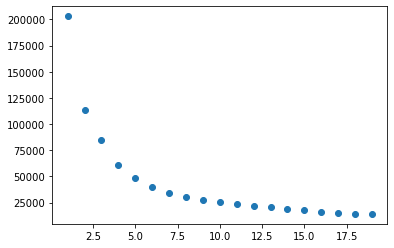

In [235]:
plt.scatter(x=mycenters['Clusters'], y=mycenters['WSS'])

# Guess 6/7 is the elbow - use that going forward

In [246]:
df_cluster = np.array(df_passes_prog[['x', 'y', 'endX', 'endY']])
kmeans = KMeans(n_clusters = 6, random_state = 100)
kmeans.fit(df_cluster)
df_passes_prog['cluster'] = kmeans.predict(df_cluster)

In [247]:
df_clusters = df_passes_prog.groupby('cluster')[['x', 'y', 'endX', 'endY']].mean().reset_index()
df_clusters

,cluster,x,y,endX,endY
0,0,22.917647,72.058824,51.311765,65.647059
1,1,79.700000,12.182353,91.058824,39.741176
2,2,41.290000,89.420000,74.290000,89.900000
3,3,40.900000,44.650000,76.441667,48.616667
4,4,78.308333,82.708333,89.316667,57.450000
5,5,26.177778,14.300000,63.677778,19.966667


In [248]:
indexes = sorted(df_passes_prog['cluster'].unique().tolist())
succ_rate = []
for idx in indexes:
    df = df_passes_prog[df_passes_prog['cluster'] == idx]
    succ = len(df[df['outcomeType'] == 'Successful'])
    fail = len(df[df['outcomeType'] == 'Unsuccessful'])
    rate = str(succ) + '/' + str(succ+fail)
    succ_rate.append(rate)

## For Home Team 

In [249]:
df_passes2 = events_df[(events_df['teamId'] == homeID) & 
                       (events_df['type'] == 'Pass')].reset_index(drop=True)
df_passes2['ProgPass'] = ''

for i in range(len(df_passes2)):
    x_0 = 120*(df_passes2['x'][i])/100
    y_0 = 80*(df_passes2['y'][i])/100
    x_1 = 120*(df_passes2['endX'][i])/100
    y_1 = 80*(df_passes2['endY'][i])/100
    
    beg_dist = np.sqrt((120 - x_0)**2 + (40 - y_0)**2)
    end_dist = np.sqrt((120 - x_1)**2 + (40 - y_1)**2)

    if end_dist/beg_dist <= 0.75:
        df_passes2['ProgPass'][i] = 1
    else:
        df_passes2['ProgPass'][i] = 0

df_passes_prog2 = df_passes2[df_passes2['ProgPass'] == 1].reset_index(drop=True)
df_passes_prog2 = df_passes_prog2[['x', 'y', 'endX', 'endY', 'outcomeType']]

df_cluster2 = np.array(df_passes_prog2[['x', 'y', 'endX', 'endY']])
kmeans.fit(df_cluster2)
df_passes_prog2['cluster'] = kmeans.predict(df_cluster2)
df_clusters2 = df_passes_prog2.groupby('cluster')[['x', 'y', 'endX', 'endY']].mean().reset_index()

indexes2 = sorted(df_passes_prog2['cluster'].unique().tolist())
succ_rate2 = []
for idx in indexes2:
    df = df_passes_prog2[df_passes_prog2['cluster'] == idx]
    succ = len(df[df['outcomeType'] == 'Successful'])
    fail = len(df[df['outcomeType'] == 'Unsuccessful'])
    rate = str(succ) + '/' + str(succ+fail)
    succ_rate2.append(rate)
succ_rate2

['11/29', '4/10', '8/26', '4/11', '5/13', '3/9']

## Carries 

In [250]:
df_carries = pd.DataFrame()
min_len = 3
max_len = 60
min_time = 1
max_time = 12

for idx, match_event in events_df.iterrows():
    if idx == len(events_df) - 1:
        break
    
    cur_team = match_event['teamId']
    idx_next = idx + 1
    events_df_next = events_df.loc[idx_next]
    take_ons = 0
    loop = True
    count = 0 
    
    while loop:
        next_events = events_df.loc[idx_next]
        
        if next_events['type'] == 'TakeOn' and next_events['outcomeType'] == 'Successful':
            take_ons += 1
            loop = True
        
        elif (next_events['type'] == 'TakeOn' and next_events['outcomeType'] == 'Unsuccessful') or (next_events['teamId'] != cur_team and next_events['type'] == 'Challenge' and next_events['outcomeType'] == 'Unsuccessful') or (next_events['type'] == 'Foul'):
            loop = True
            
        else:
            loop = False
            
        idx_next += 1
        count += 0 
        

    same_team = cur_team == next_events['teamId']
    not_ball_touch = match_event['type'] != 'BallTouch'
    dx = 105 * (match_event['endX'] - next_events['x'])/100
    dy = 68 * (match_event['endY'] - next_events['y'])/100
    min_dist = dx**2 + dy**2 >= min_len**2
    max_dist = dx**2 + dy**2 <= max_len**2
    same_period = match_event['period'] == next_events['period']
    
    valid_carry = same_team & not_ball_touch & min_dist & max_dist & same_period 
    
    if valid_carry:
        carry = pd.DataFrame()
        prev = match_event
        nxt = next_events
        carry.loc[0, 'eventId'] = prev['eventId'] + count
        carry['id'] = prev['id'] + count
        carry['teamId'] = nxt['teamId']
        carry['x'] = prev['endX']
        carry['y'] = prev['endY']
        carry['period'] = nxt['period']
        carry['type'] = carry.apply(lambda x: {'value': 99, 'displayName': 'Carry'}, axis=1)
        carry['outcomeType'] = 'Successful'
        carry['qualifiers'] = carry.apply(
            lambda x: {'type': {'value': 999, 'displayName': 'takeOns'}, 'value': str(take_ons)}, axis=1)
        carry['satisfiedEventsTypes'] = carry.apply(lambda x: [], axis=1)
        carry['isTouch'] = True
        carry['playerId'] = nxt['playerId']
        carry['playerName'] = nxt['playerName']
        carry['endX'] = nxt['x']
        carry['endY'] = nxt['y']
        
        df_carries = pd.concat([df_carries, carry], ignore_index=True, sort=False)


In [251]:
df_carries1 = df_carries[(df_carries['teamId'] == awayID)].reset_index(drop=True)

df_carries1['ProgCarry'] = ''
for i in range(len(df_carries1)):
    x_0 = 120*(df_carries1['x'][i])/100
    y_0 = 80*(df_carries1['y'][i])/100
    x_1 = 120*(df_carries1['endX'][i])/100
    y_1 = 80*(df_carries1['endY'][i])/100
    
    beg_dist = np.sqrt((120 - x_0)**2 + (40 - y_0)**2)
    end_dist = np.sqrt((120 - x_1)**2 + (40 - y_1)**2)

    if end_dist/beg_dist <= 0.75:
        df_carries1['ProgCarry'][i] = 1
    else:
        df_carries1['ProgCarry'][i] = 0
        
# prog_carries = pd.DataFrame(df_carries.groupby('playerName')['ProgCarry'].sum()).reset_index()
df_carries1 = df_carries1[df_carries1['ProgCarry'] == 1].reset_index(drop=True)
df_carries1 = df_carries1[['x', 'y', 'endX', 'endY']]
df_carries1

,x,y,endX,endY
0,61.9,11.1,69.5,26.7
1,59.1,21.7,88.3,62.9
2,44.0,74.7,67.4,82.3
3,47.1,15.0,79.3,17.9
4,31.3,21.2,58.1,6.2
5,68.8,24.0,79.0,26.1
6,54.6,66.3,72.3,66.9


In [252]:
carry_cluster = np.array(df_carries1[['x', 'y', 'endX', 'endY']])
kmeans_carry = KMeans(n_clusters = 3, random_state = 100)
kmeans_carry.fit(carry_cluster)
df_carries1['cluster'] = kmeans_carry.predict(carry_cluster)
df_clusters3 = df_carries1.groupby('cluster')[['x', 'y', 'endX', 'endY']].mean().reset_index()
df_clusters3

,cluster,x,y,endX,endY
0,0,52.275,17.825,71.475,19.225
1,1,49.300,70.500,69.850,74.600
2,2,59.100,21.700,88.300,62.900


In [253]:
indexes3 = sorted(df_carries1['cluster'].unique().tolist())
succ_rate3 = []
for idx in indexes3:
    df = df_carries1[df_carries1['cluster'] == idx]
    num = len(df)
    succ_rate3.append(str(num))
succ_rate3

['4', '2', '1']

## For Home Team 

In [254]:
df_carries2 = df_carries[(df_carries['teamId'] == homeID)].reset_index(drop=True)

df_carries2['ProgCarry'] = ''
for i in range(len(df_carries2)):
    x_0 = 120*(df_carries2['x'][i])/100
    y_0 = 80*(df_carries2['y'][i])/100
    x_1 = 120*(df_carries2['endX'][i])/100
    y_1 = 80*(df_carries2['endY'][i])/100
    
    beg_dist = np.sqrt((120 - x_0)**2 + (40 - y_0)**2)
    end_dist = np.sqrt((120 - x_1)**2 + (40 - y_1)**2)

    if end_dist/beg_dist <= 0.75:
        df_carries2['ProgCarry'][i] = 1
    else:
        df_carries2['ProgCarry'][i] = 0
        
# prog_carries = pd.DataFrame(df_carries.groupby('playerName')['ProgCarry'].sum()).reset_index()
df_carries2 = df_carries2[df_carries2['ProgCarry'] == 1].reset_index(drop=True)
df_carries2 = df_carries2[['x', 'y', 'endX', 'endY']]


carry_cluster = np.array(df_carries2[['x', 'y', 'endX', 'endY']])
kmeans_carry = KMeans(n_clusters = 3, random_state = 100)
kmeans_carry.fit(carry_cluster)
df_carries2['cluster'] = kmeans_carry.predict(carry_cluster)
df_clusters4 = df_carries2.groupby('cluster')[['x', 'y', 'endX', 'endY']].mean().reset_index()

indexes4 = sorted(df_carries2['cluster'].unique().tolist())
succ_rate4 = []
for idx in indexes4:
    df = df_carries2[df_carries2['cluster'] == idx]
    num = len(df)
    succ_rate4.append(str(num))
succ_rate4

['7', '7', '4']

## Plot

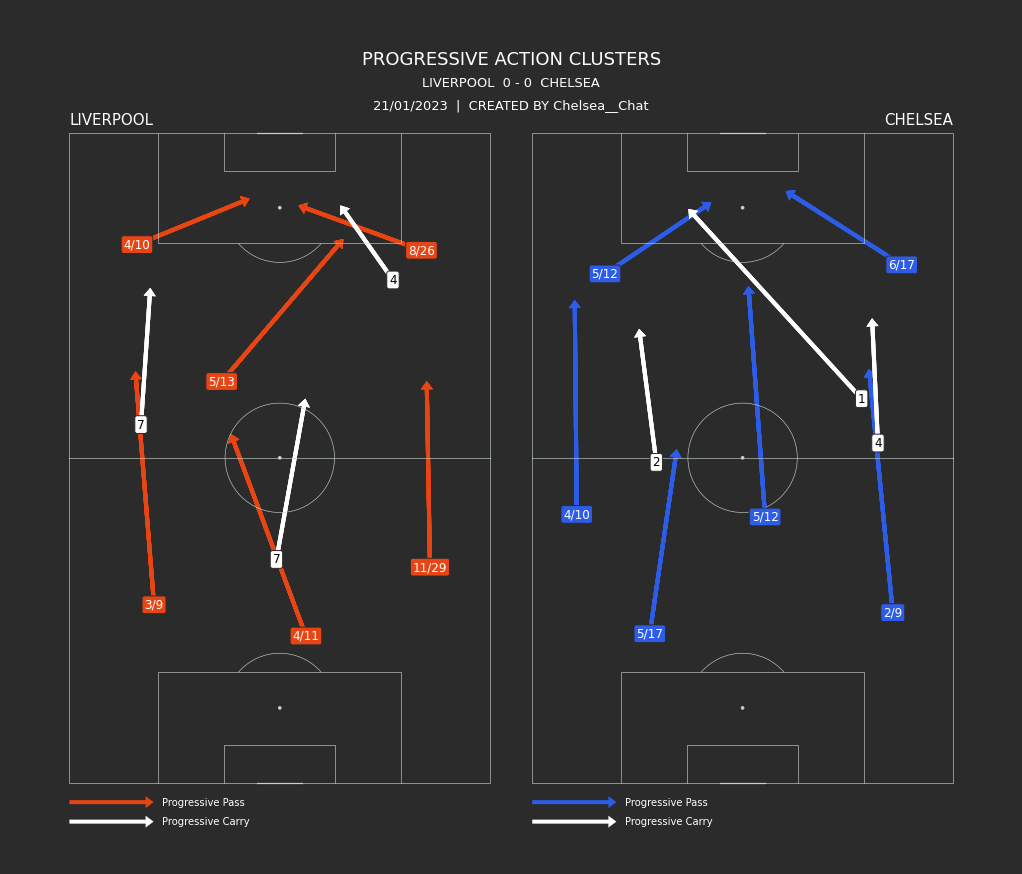

In [255]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.colors
# mpl.rcParams['figure.dpi'] = 800

FIGWIDTH, FIGHEIGHT = 14, 10
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
FIG_ASPECT = FIGWIDTH / FIGHEIGHT
fig = plt.figure(figsize=FIGSIZE)

pitch1 = VerticalPitch(pitch_type='opta', pitch_color='#2B2B2B', line_color='#c7d5cc', pad_left = 10,
                       line_zorder=2, pad_bottom=20, pad_right=5,   linewidth=0.6, pitch_length=5, pad_top=30)
pitch2 = VerticalPitch(pitch_type='opta', pitch_color='#2B2B2B', line_color='#c7d5cc', pad_right = 10,
                       line_zorder=2,  pad_bottom=20, pad_left=5,  linewidth=0.6, pitch_length=5, pad_top=30)

fig.set_facecolor("#2B2B2B")

TITLE_HEIGHT = 0.1 # title axes are 10% of the figure height

#  width of pitch axes as percent of the figure width
TOP_WIDTH = 0.48
BOTTOM_WIDTH = 0.25

# calculate the horizontal space between axes (and figure sides) in percent of the figure width
TOP_SPACE = (1 - (TOP_WIDTH * 2)) / 2
BOTTOM_SPACE = (1 - (BOTTOM_WIDTH * 3)) / 2

# calculate the height of the pitch axes in percent of the figure height
height1 = (TOP_WIDTH / pitch1.ax_aspect * FIG_ASPECT)
height2 = (TOP_WIDTH / pitch2.ax_aspect * FIG_ASPECT)


# calculate pitch offsets from center / title locations
vertical_axes_space = (1 - (height1 + TITLE_HEIGHT + TITLE_HEIGHT)) / 5
bottom_offset = ((1 - height2) / 2) - vertical_axes_space
title1_bottom = 1 - vertical_axes_space - TITLE_HEIGHT
title2_bottom = 1 - (vertical_axes_space * 3) - (TITLE_HEIGHT * 2) - height1
top_offset = (1 - title1_bottom - title2_bottom - TITLE_HEIGHT) / 2



# top left
LEFT1 = TOP_SPACE
bottom1 = (1 - height1) / 2 - top_offset
ax1 = fig.add_axes((LEFT1, bottom1, TOP_WIDTH, height1))
pitch1.draw(ax=ax1)

# top right
left2 = (TOP_SPACE ) + (TOP_WIDTH)
bottom2 = (1 - height2) / 2 - top_offset
ax2 = fig.add_axes((left2, bottom2, TOP_WIDTH, height2))
pitch2.draw(ax=ax2)

ax_title2 = fig.add_axes((0, title1_bottom-0.05, 1, TITLE_HEIGHT-0.05))
ax_title2.axis('off')
ax_title2.text(left2 ,0.45,
               f'{home_name} {score} { away_name}'.upper(),
               color='white', size=13, va='center', ha='center', fontname = 'Sans Serif')
ax_title2.text(left2 ,1.1,
               'Progressive Action Clusters'.upper(),
               color='white', size=18, va='center', ha='center', fontname = 'Sans Serif')
ax_title2.text(left2 ,-0.15,
               f'{date_str}  |  CREATED BY Chelsea__Chat',
               color='white', size=13, va='center', ha='center', fontname = 'Sans Serif')


pitch1.annotate(text=home_name.upper(), 
                          xytext=(102, 100), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 15, ax = ax1)

pitch2.annotate(text=away_name.upper(), 
                          xytext=(102, 0), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 15, ax = ax2)

for index, row in df_clusters.iterrows():
    pitch2.arrows(df_clusters.x, df_clusters.y,
                  df_clusters.endX, df_clusters.endY, lw=0.5,
                  color=away_color, zorder=1, ax=ax2, headlength=2, headwidth=3, headaxislength=2)
    x = float(df_clusters.x[index])
    y = float(df_clusters.y[index])
    pitch2.annotate(text=str(succ_rate[index]), 
                    bbox=dict(facecolor=away_color, edgecolor='#2B2B2B', boxstyle='round,pad=.2', alpha=1),
                    xytext=(x, y), xy=(60, 40), ha='center', va='center',
                    fontname = 'Sans Serif', fontsize=12, color='white', ax=ax2)
    


for index, row in df_clusters2.iterrows():
    pitch1.arrows(df_clusters2.x, df_clusters2.y,
                  df_clusters2.endX, df_clusters2.endY, lw=0.5,
                  color=home_color, zorder=1, ax=ax1, headlength=2, headwidth=3, headaxislength=2)
    x = float(df_clusters2.x[index])
    y = float(df_clusters2.y[index])
    pitch1.annotate(text=str(succ_rate2[index]), 
                    bbox=dict(facecolor=home_color, edgecolor='#2B2B2B', boxstyle='round,pad=.2', alpha=1),
                    xytext=(x, y), xy=(60, 40), ha='center', va='center',
                    fontname = 'Sans Serif', fontsize=12, color='white', ax=ax1)
    
    

for index, row in df_clusters3.iterrows():
    pitch2.arrows(df_clusters3.x, df_clusters3.y,
                  df_clusters3.endX, df_clusters3.endY, lw=0.5, 
                  color='white', zorder=1, ax=ax2, headlength=2, headwidth=3, headaxislength=2)
    x = float(df_clusters3.x[index])
    y = float(df_clusters3.y[index])
    pitch2.annotate(text=str(succ_rate3[index]), 
                    bbox=dict(facecolor='white', edgecolor='#2B2B2B', boxstyle='round,pad=.2', alpha=1),
                    xytext=(x, y), xy=(60, 40), ha='center', va='center',
                    fontname = 'Sans Serif', fontsize=12, color='black', ax=ax2)
    
    

for index, row in df_clusters4.iterrows():
    pitch1.arrows(df_clusters4.x, df_clusters4.y,
                  df_clusters4.endX, df_clusters4.endY, lw=0.5, 
                  color='white', zorder=1, ax=ax1, headlength=2, headwidth=3, headaxislength=2)
    x = float(df_clusters4.x[index])
    y = float(df_clusters4.y[index])
    pitch1.annotate(text=str(succ_rate4[index]), 
                    bbox=dict(facecolor='white', edgecolor='#2B2B2B', boxstyle='round,pad=.2', alpha=1),
                    xytext=(x, y), xy=(60, 40), ha='center', va='center',
                    fontname = 'Sans Serif', fontsize=12, color='black', ax=ax1)
    
    
pitch1.arrows(-3, 100, -3, 80, lw=0.5, color=home_color, zorder=1, ax=ax1,
             headlength=2, headwidth=3, headaxislength=2)
pitch1.annotate(text='Progressive Pass', 
                          xytext=(-3, 78), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 10, ax = ax1)
pitch1.arrows(-6, 100, -6, 80, lw=0.5, color='white', zorder=1, ax=ax1,
             headlength=2, headwidth=3, headaxislength=2)
pitch1.annotate(text='Progressive Carry', 
                          xytext=(-6, 78), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 10, ax = ax1)



pitch2.arrows(-3, 100, -3, 80, lw=0.5, color=away_color, zorder=1, ax=ax2,
             headlength=2, headwidth=3, headaxislength=2)
pitch2.annotate(text='Progressive Pass', 
                          xytext=(-3, 78), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 10, ax = ax2)
pitch2.arrows(-6, 100, -6, 80, lw=0.5, color='white', zorder=1, ax=ax2,
             headlength=2, headwidth=3, headaxislength=2)
pitch2.annotate(text='Progressive Carry', 
                          xytext=(-6, 78), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 10, ax = ax2)


fig.savefig('ProgClusters.png', 
            bbox_inches="tight",
            edgecolor="none",
            dpi=600)